### 패키지 로딩

In [23]:
# data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# time series model
import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# scoring
from sklearn.metrics import *

# requests
import requests

# json
import json

# warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

# imputation
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# scoring
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# use model
from catboost import CatBoostRegressor

# bayesian optimization
from bayes_opt import BayesianOptimization

# make events
from itertools import product

# seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

### 데이터 크롤링

In [2]:
### 크롤링 함수 생성
def lead_time(pageNo, Year) :
    url = 'http://data.ex.co.kr/openapi/specialAnal/intercityLeadTime'
    parameters = {"key":"9262920512",
                 "type":"json",
                 "numOfRows":"100",
                 "iStUnitCode" : "101",
                 "iEdUnitCode" : "140",
                 "pageNo": str(pageNo),
                 "iYear":str(Year)}
    response = requests.get(url, params=parameters)
    data = response.json()
    return data

### 크롤링 함수 실행
def seoul_busan(Year) :
    data1 = lead_time(1, Year)
    data2 = lead_time(2, Year)
    data3 = lead_time(3, Year)
    data4 = lead_time(4, Year)
    data1 = pd.DataFrame(data1["intercityLeadTimeLists"])
    data2 = pd.DataFrame(data2["intercityLeadTimeLists"])
    data3 = pd.DataFrame(data3["intercityLeadTimeLists"])
    data4 = pd.DataFrame(data4["intercityLeadTimeLists"])
    data = pd.concat([data1, data2, data3, data4], axis=0)
    return data

In [ ]:
### 2020~2022 데이터 끌어오기
data_2022 = seoul_busan(2022)
data_2021 = seoul_busan(2021)
data_2020 = seoul_busan(2020)

### 필요없는 열 제거
data_2022 = data_2022.drop(columns = ["iYear","iStUnitCode","iEdUnitCode","stUnitNm","stUnitCode","edUnitNm","edUnitCode","sphlDfttScopTypeCode","dirNm","dirCode","message","code","sphlDfttCode"])
data_2021 = data_2021.drop(columns = ["iYear","iStUnitCode","iEdUnitCode","stUnitNm","stUnitCode","edUnitNm","edUnitCode","sphlDfttScopTypeCode","dirNm","dirCode","message","code","sphlDfttCode"])
data_2020 = data_2020.drop(columns = ["iYear","iStUnitCode","iEdUnitCode","stUnitNm","stUnitCode","edUnitNm","edUnitCode","sphlDfttScopTypeCode","dirNm","dirCode","message","code","sphlDfttCode"])
data_2022.columns = ["시각","년","이벤트","이벤트시점기준이동","이동시간"]
data_2021.columns = ["시각","년","이벤트","이벤트시점기준이동","이동시간"]
data_2020.columns = ["시각","년","이벤트","이벤트시점기준이동","이동시간"]

### 데이터 합치기 및 정제
data = pd.concat([data_2022, data_2021, data_2020], axis=0)
data = data[data["이벤트"] != "연말연시"]
data["이벤트시점기준이동"].replace({"D-3":0, "D-2":1, "D-1":2, "D":3, "D+1":4, "D+2":5,"D+3": 6}, inplace=True)
data["이벤트"].replace({"설날" : "01","추석" : "02"}, inplace=True)
data["시간"] = data["년"] + data["이벤트"] + data["이벤트시점기준이동"].astype(str) +  data["시각"]
data.drop(columns = ["이벤트","년","시각","이벤트시점기준이동"], inplace=True)
data.sort_values(by=["시간"], inplace=True)
data.reset_index(drop=True, inplace=True)
data = data[["시간","이동시간"]]
data["event"] = data["시간"].str.slice(start = 0, stop = 7)
data["시각"] = data["시간"].str.slice(start = 7, stop = 9)
event_list = data["event"].unique()
data_list = []
for i in range(len(event_list)) :
    time = pd.DataFrame()
    time["시각"] = [i for i in range(0,24)]
    time["시각"] = np.where(time["시각"]<10 ,"0" + time["시각"].astype(str), time["시각"].astype(str))
    temp = data[data["event"] == event_list[i]]
    temp = pd.merge(time, temp, how="left", on="시각")
    temp["이동시간"] = temp["이동시간"].fillna(method="ffill")
    temp["event"] = temp["event"].fillna(method = "ffill")
    temp["시각"] = temp["event"].astype(str) + temp["시각"].astype(str)
    temp.drop(columns = ["event","시간"], inplace=True)
    data_list.append(temp)
data = pd.concat(data_list,axis = 0)
data.reset_index(drop=True, inplace=True)

### target 데이터 정의
target = pd.DataFrame()
target["시각"] = ["2022021"+i for i in ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]]
target["이동시간"] = np.nan
data = pd.concat([data,target],axis = 0)

### 24시간~48시간 전 columns 생성
data["이동시간_lag1"]=data["이동시간"].shift(24)
data["이동시간_lag2"]=data["이동시간"].shift(25)
data["이동시간_lag3"]=data["이동시간"].shift(26)
data["이동시간_lag4"]=data["이동시간"].shift(27)
data["이동시간_lag5"]=data["이동시간"].shift(28)
data["이동시간_lag6"]=data["이동시간"].shift(29)
data["이동시간_lag7"]=data["이동시간"].shift(30)
data["이동시간_lag8"]=data["이동시간"].shift(31)
data["이동시간_lag9"]=data["이동시간"].shift(32)
data["이동시간_lag10"]=data["이동시간"].shift(33)
data["이동시간_lag11"]=data["이동시간"].shift(34)
data["이동시간_lag12"]=data["이동시간"].shift(35)
data["이동시간_lag13"]=data["이동시간"].shift(36)
data["이동시간_lag14"]=data["이동시간"].shift(37)
data["이동시간_lag15"]=data["이동시간"].shift(38)
data["이동시간_lag16"]=data["이동시간"].shift(39)
data["이동시간_lag17"]=data["이동시간"].shift(40)
data["이동시간_lag18"]=data["이동시간"].shift(41)
data["이동시간_lag19"]=data["이동시간"].shift(42)
data["이동시간_lag20"]=data["이동시간"].shift(43)
data["이동시간_lag21"]=data["이동시간"].shift(44)
data["이동시간_lag22"]=data["이동시간"].shift(45)
data["이동시간_lag23"]=data["이동시간"].shift(46)
data["이동시간_lag24"]=data["이동시간"].shift(47)

### data와 target 분할
data = data[data["이동시간_lag24"].isna() == False]
target = data[data["이동시간"].isna()].iloc[3:27,]

### data셋 최종 정제
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data = data.astype(float)

### data와 target 저장
# data.to_csv("data.csv",index = False)
# target.to_csv("target.csv",index = False)

### Time series Decomposition

In [93]:
data = pd.read_csv("data.csv")
target = pd.read_csv("target.csv")
data = pd.concat([data,target],axis = 0)

In [95]:
data.reset_index(inplace = True, drop = True)

In [97]:
time_data = data[["이동시간_lag1"]]
time_data = time_data.reset_index()
time_data["index"] = pd.to_datetime("2021-01-01") + pd.to_timedelta(time_data["index"], unit = "H")
time_data.index = time_data["index"]
time_data.drop(columns = ["index"],inplace = True)

In [99]:
result = seasonal_decompose(time_data,two_sided=False,extrapolate_trend=True)

In [100]:
data["resid"] = result.resid.values
data["trend"] = result.trend.values
data["seasonal"] = result.seasonal.values

In [121]:
# data[data["이동시간"].isna()].to_csv("target.csv",index = False)
# data[data["이동시간"].isna() == False].to_csv("data.csv",index = False)

### Bayesian Optimization

In [125]:
### feature와 target 분할
data = pd.read_csv("data.csv")
X = data.drop(columns = ["이동시간","시각","Unnamed: 0"])
y = data["이동시간"]

In [127]:
### train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle = False) # suffle을 하는 이유는 어짜피 시계열 데이터에서 무작위 데이터로 변경했기 때문이다.

In [137]:
### 모델 fitting 함수 정의
def fit_model(X,y,X_test,depth,bagging_temperature,learning_rate,subsample):
    cat_model = CatBoostRegressor(depth = int(depth),
                                  bagging_temperature=bagging_temperature,
                                  learning_rate=learning_rate,
                                  random_state=1339,#
                                  verbose=0,#
                                  subsample=subsample,
                                  eval_metric='MAPE'
                                  ).fit(X,y)
    cat_predict = cat_model.predict(X_test)
    return cat_predict

In [138]:
def object_function(depth,bagging_temperature,learning_rate,subsample) :
    y_predict = fit_model(X_train, y_train, X_test,depth,bagging_temperature,learning_rate,subsample)
    score=metrics.mean_absolute_percentage_error(y_test, y_predict)
    return -score 

In [139]:
# pbounds : 하이퍼 파라미터들의 범위 설정하기
pbounds = { 'depth': (1, 16),
            'bagging_temperature': (1, 10),
            'learning_rate': (0.01, 1.0),
            'subsample' : (0.01,1),
            }

In [141]:
# 베이지안 옵티마이저 fitting
#bo = BayesianOptimization(f = object_function, pbounds = pbounds, random_state = 1,verbose = 2)
#bo.maximize(init_points = 5, n_iter = 10,acq = 'ei',xi = 0.01)

# 베이지안 옵티마이저 결과
#|   iter    |  target   | baggin... |   depth   | learni... | subsample |
#-------------------------------------------------------------------------
#|  1        | -0.1227   |  4.753    |  11.8     |  0.01011  |  0.3093   |
#|  2        | -0.1353   |  2.321    |  2.385    |  0.1944   |  0.3521   |
#|  3        | -0.1305   |  4.571    |  9.082    |  0.425    |  0.6884   |

### 모델 학습

In [142]:
### 데이터 불러오기
train = pd.read_csv("data.csv")
target = pd.read_csv("target.csv")
### feature와 target정의
X = train.drop(columns = ['시각','이동시간'])
y = train['이동시간']
### 시각화 함수 정의
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()


In [150]:
### 10% 데이터 맞추기 - 단일 Catboost
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle = False) # suffle을 하는 이유는 어짜피 시계열 데이터에서 무작위 데이터로 변경했기 때문이다.
# catboost regressor
cat_test =  CatBoostRegressor(depth = int(11.8),bagging_temperature = 4.753, learning_rate =  0.01011, subsample = 0.3093, random_state=1339,verbose = 0,eval_metric='MAPE').fit(X_train,y_train)
# predict
y_pred1 = cat_test.predict(X_test)
# MAPE
MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred1)
print(MAPE)

0.13091643358837007


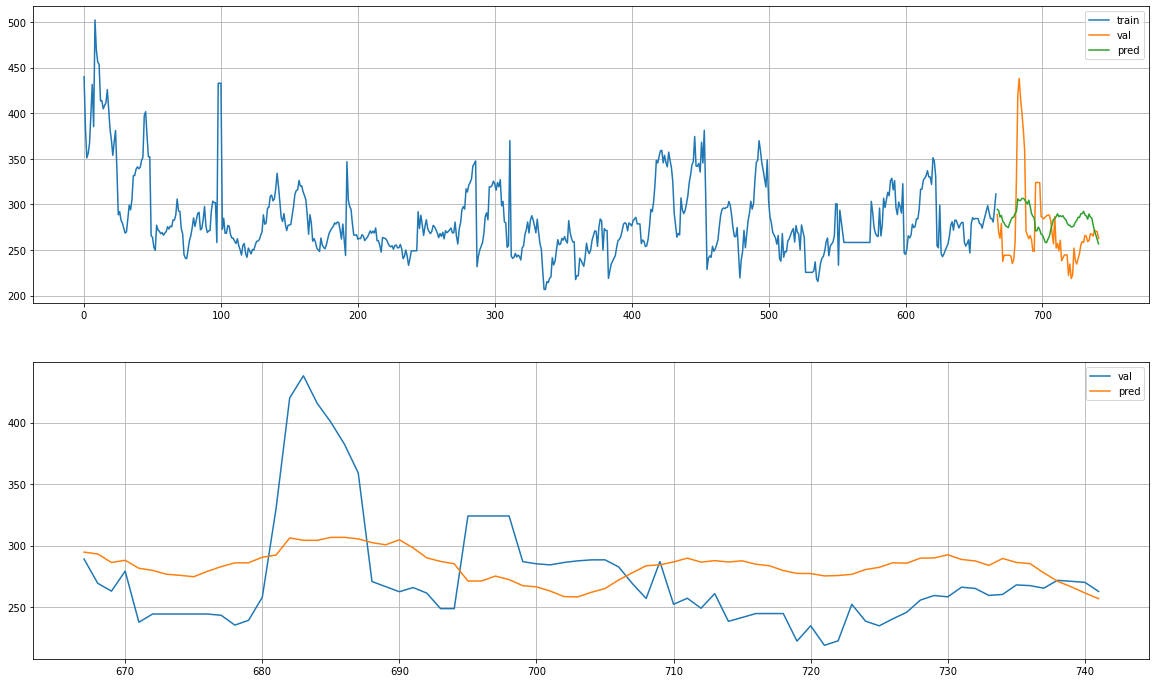

In [151]:
plot_model_result(y_train,y_test, y_pred1)

In [152]:
### 10% 데이터 맞추기 - 앙상블
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle = False) # suffle을 하는 이유는 어짜피 시계열 데이터에서 무작위 데이터로 변경했기 때문이다.
# catboost regressor
cat1_test =  CatBoostRegressor(depth = int(9.082),bagging_temperature = 4.571, learning_rate =  0.425, subsample = 0.6884, random_state=1339,verbose = 0,eval_metric='MAPE').fit(X_train,y_train)
cat2_test =  CatBoostRegressor(depth = int(2.385),bagging_temperature = 2.321, learning_rate =  0.1944, subsample = 0.3521, random_state=1339,verbose = 0,eval_metric='MAPE').fit(X_train,y_train)
cat3_test =  CatBoostRegressor(depth = int(11.8),bagging_temperature = 4.753, learning_rate =  0.01011, subsample = 0.3093, random_state=1339,verbose = 0,eval_metric='MAPE').fit(X_train,y_train)
# predict
y1_pred = cat1_test.predict(X_test)
y2_pred = cat2_test.predict(X_test)
y3_pred = cat3_test.predict(X_test)
# MAPE
y_pred_esb = (y1_pred + y2_pred + y3_pred)/3
MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred_esb)
print(MAPE)

0.13574296587756307


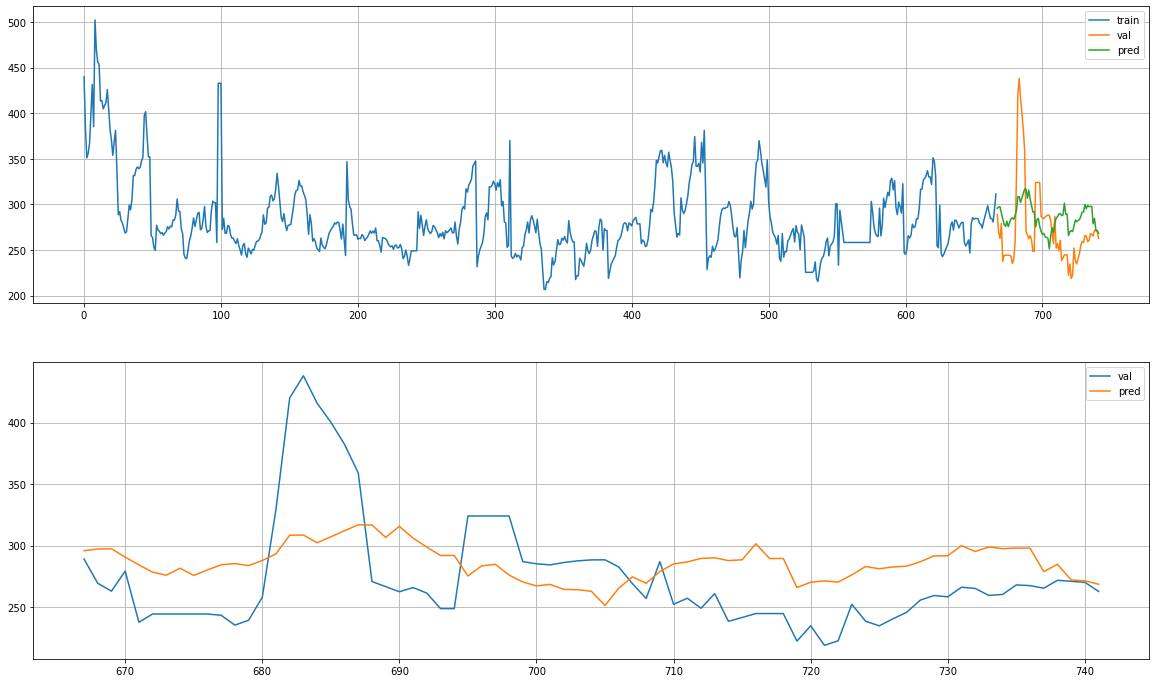

In [153]:
plot_model_result(y_train,y_test, y_pred_esb)

### 예측

In [165]:
### train_x, train_y 나누기
train_x = pd.read_csv("data.csv").drop(columns = ["Unnamed: 0","시각","이동시간"])
train_y = pd.read_csv("data.csv")["이동시간"]

### model fitting
cat =  CatBoostRegressor(depth = int(11.8),bagging_temperature = 4.753, learning_rate =  0.01011, subsample = 0.3093, random_state=1339,verbose = 0,eval_metric='MAPE').fit(train_x,train_y)

### Target 데이터 불러오기
target = pd.read_csv("target.csv").drop(columns = ["Unnamed: 0","시각","이동시간"])

### 결과 저장
pd.DataFrame(cat.predict(target)).rename(columns = {0:"이동시간"}).to_csv("result.csv")